In [24]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from  matplotlib.colors import LinearSegmentedColormap
import pandas as pd
import seaborn as sn
import sys
from pathlib import Path
from tqdm import tqdm
import scipy

import torch.nn as nn
from torch import Tensor
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# import custom functions from src folder
module_path = str(Path.cwd() / "../src")

if module_path not in sys.path:
    sys.path.append(module_path)

from SequentialNet import SequentialNet
from machine_learning import *
from util import *

In [25]:
def word_to_int(df):
    # Red = 0, blue = 1
    df["class"] = 0
    df_copy = df.copy()
    mask = df_copy["color"] == "blue"
    df.loc[mask, "class"] = 1
    return df


In [26]:
def plot_results(df, pred_key, ax, suptitle, error_key="None"):
    ax.set_title(suptitle)
    cmap = red_blue_cmap()
    if error_key == "None":
        sn.scatterplot(data = df, x="x1", y="x2", ax = ax, hue=pred_key, 
                    hue_norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False),
                        palette=cmap, legend=False)
    else:
        sn.scatterplot(data = df, x="x1", y="x2", ax = ax, hue=pred_key, 
                       size=error_key, size_norm = (0.1, 0.3), sizes=(10, 200),
                        hue_norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False),
                        palette=cmap, legend=False)
    
    ax.set_xlim(-25, 25)
    ax.set_ylim(-25, 25)
    ax.set_xlabel(r"x$_1$", fontsize=14)
    ax.set_ylabel(r"x$_2$", fontsize=14)

    ax.tick_params(which="both", direction="inout", bottom=True, left=True, labelsize=14, pad=5, length=4, width=1)
    ax.tick_params(which="major", length=6)
    ax.set_xticks([-20, 0, 20])
    ax.set_yticks([-20, 0, 20])
    ax.set_aspect('equal', adjustable='box')
    ax.minorticks_on()
    return ax


In [27]:
def predict_grid(model, x1_key, x2_key, device, mcdropout:bool = False, nx:int = 100):
    x1_lim = 25
    x2_lim = 25
    x1 = np.linspace(-x1_lim, x1_lim, nx)
    x2 = np.linspace(-x2_lim, x2_lim, nx)
    xx1, xx2 = np.meshgrid(x1, x2)
    df = pd.DataFrame(columns = ["x1", "x2"], index = range(len(xx1.flatten())))
    df["x1"] = xx1.flatten()
    df["x2"] = xx2.flatten()
    df = cartesian_to_polar_df(df, "x1", "x2", "r_x", "a_x")

    X_gridtest = torch.Tensor(np.dstack((df[x1_key], df[x2_key]))).to(torch.float32)[0]
    Y_gridtest = torch.zeros(X_gridtest.shape)
    gridtest_dataset = torch.utils.data.TensorDataset(X_gridtest, Y_gridtest)
    if mcdropout:
        mean_val, variance_val = mc_predictions(model, gridtest_dataset, 2**8, 100, 2, len(df))
        preds = np.argmax(mean_val, axis=-1).flatten()
        df["Prediction_MC"] = preds
        #Get average softmax score for blue
        df["Confidence_MC"] = scipy.special.softmax(mean_val, axis=-1)[:,1]
        # Error is the same for both scores
        df["Error_MC"] = np.sqrt(variance_val[:,1])
    else:
        truth, logits = predict_classifier(model, gridtest_dataset, 2, 100, device)
        preds = torch.argmax(logits, dim=-1).flatten()
        df["Prediction"] = preds
        #Get softmax score for red
        df["Confidence"] = torch.softmax(logits, dim=-1)[:,1]
    return df

In [28]:
# Set up device
device = (
    "cuda:0"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device {torch.cuda.get_device_name(0)}")

Using cuda:0 device NVIDIA TITAN V


In [29]:
# Machine learning options
x1_key = "x1"
x2_key = "x2"
n_data = [250, 500, 1000, 2000, 3000, 4000, 5000]
patience = 20
load_ensemble_values = True

#Data constants
R2 = 3
k_red = 7
k_blue = 3
R1_min = 6
scale = 1
vary_a1 = False
vary_R2 = False
p_red = 0.5
polar = True
tag = f'r2_{R2}_kr{k_red}_kb{k_blue}_r1min{R1_min}_s{scale}_vary_r2_{vary_R2}_vary_a1_{vary_a1}_pRed_{p_red}'

# Read files
train_n = 50000
trainfile = f"train_n_{train_n}_{tag}"
valfile = f"val_n_5000_{tag}"
truthfile = f"analytical_solution_x1_x2_grid_{tag}_nxMC_100_nr1MC_50"
testfile = "x1_x2_grid"

train_data = pd.read_csv(f"../data/{trainfile}.csv")
val_data = pd.read_csv(f"../data/{valfile}.csv")
test_data = pd.read_csv(f"../data/{testfile}.csv")
truth_data = pd.read_csv(f"../analytical/results/{truthfile}.csv")

#Correct analytical solution if class distribution is not equal
if p_red != 0.5:
    truth_data["P_red_and_x"] = truth_data["P_red_and_x"]*(p_red)/0.5
    truth_data["P_blue_and_x"] = truth_data["P_blue_and_x"]*(1-p_red)/0.5
    truth_data["P_x"] = truth_data["P_red_and_x"] + truth_data["P_blue_and_x"]
    truth_data["P_red_given_x"] = truth_data["P_red_and_x"]/truth_data["P_x"]
    truth_data["P_blue_given_x"] = truth_data["P_blue_and_x"]/truth_data["P_x"]

# Prepare data for pytorch
train_data = word_to_int(train_data)
val_data = word_to_int(val_data)

X_train = torch.Tensor(np.dstack((train_data[x1_key], train_data[x2_key]))).to(torch.float32)[0]
Y_train = label_maker(train_data["class"], 2)

X_val = torch.Tensor(np.dstack((val_data[x1_key], val_data[x2_key]))).to(torch.float32)[0]
Y_val = label_maker(val_data["class"], 2)

X_test = torch.Tensor(np.dstack((test_data[x1_key], test_data[x2_key]))).to(torch.float32)[0]
Y_test = torch.zeros(X_test.shape)

In [30]:
val_dataset = torch.utils.data.TensorDataset(X_val, Y_val)
val_data_dfs = [pd.read_csv(f"../data/{valfile}.csv") for i in range(len(n_data))]
grid_dfs = [pd.DataFrame(columns = ["x1", "x2", "r_x", "a_x"], index = range(100*100)) for i in range(len(n_data))]
grid_MC_dfs = [pd.DataFrame(columns = ["x1", "x2", "r_x", "a_x"], index = range(100*100)) for i in range(len(n_data))]

In [31]:
for i in range(len(n_data)):
    # Create datasets for pytorch
    train_dataset = torch.utils.data.TensorDataset(X_train[0:n_data[i]], Y_train[0:n_data[i]])

    # Create model
    model = SequentialNet(L=1024*2, n_hidden=5, activation="relu", in_channels=2, out_channels=2, p=0.2).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Train model
    training_results = train_classifier(model, train_dataset, 
                            val_dataset, batchsize=2**8, epochs = 80, 
                            device = device, optimizer = optimizer, early_stopping=patience)

    # Predict with just model
    truth, logits = predict_classifier(model, val_dataset, 2, 100, device)
    preds = torch.argmax(logits, dim=-1).flatten()
    val_data_dfs[i]["Prediction"] = preds
    val_data_dfs[i]["Truth"] = truth

    #Get softmax score for blue
    val_data_dfs[i]["Confidence"] = torch.softmax(logits, dim=-1)[:,1]
    grid_dfs[i] = predict_grid(model, x1_key, x2_key, device)

    # Predict with MC dropout
    mean_val, variance_val = mc_predictions(model, val_dataset, 2**8, 200, 2, len(val_dataset))
    preds = np.argmax(mean_val, axis=-1).flatten()
    val_data_dfs[i]["Prediction_MC"] = preds
    val_data_dfs[i]["Confidence_MC"] = scipy.special.softmax(mean_val, axis=-1)[:,1]
    # Error is the same for both scores
    val_data_dfs[i]["Error_MC"] = np.sqrt(variance_val[:,0])
    grid_MC_dfs[i] = predict_grid(model, x1_key, x2_key, device, mcdropout=True)
    

  8%|▊         | 6/80 [00:00<00:02, 27.52it/s]

 36%|███▋      | 29/80 [00:01<00:02, 24.38it/s]


Stopping training early at epoch 29


100%|██████████| 100/100 [00:00<00:00, 454.21it/s]


Starting MC dropout inference: 


100%|██████████| 200/200 [00:17<00:00, 11.45it/s]


Starting MC dropout inference: 


 68%|██████▊   | 54/80 [00:04<00:02, 12.37it/s]


Stopping training early at epoch 54


100%|██████████| 100/100 [00:00<00:00, 452.61it/s]


Starting MC dropout inference: 


100%|██████████| 200/200 [00:17<00:00, 11.43it/s]


Starting MC dropout inference: 


 36%|███▋      | 29/80 [00:08<00:15,  3.25it/s]


Stopping training early at epoch 29


100%|██████████| 100/100 [00:00<00:00, 412.39it/s]


Starting MC dropout inference: 


100%|██████████| 200/200 [00:18<00:00, 10.91it/s]


Starting MC dropout inference: 


100%|██████████| 100/100 [00:00<00:00, 409.50it/s]


Starting MC dropout inference: 


100%|██████████| 200/200 [00:18<00:00, 10.79it/s]


Starting MC dropout inference: 


 98%|█████████▊| 78/80 [00:43<00:01,  1.79it/s]


Stopping training early at epoch 78


100%|██████████| 100/100 [00:00<00:00, 405.80it/s]


Starting MC dropout inference: 


100%|██████████| 200/200 [00:18<00:00, 10.98it/s]


Starting MC dropout inference: 


100%|██████████| 100/100 [00:00<00:00, 406.46it/s]


Starting MC dropout inference: 


100%|██████████| 200/200 [00:18<00:00, 10.94it/s]


Starting MC dropout inference: 


 78%|███████▊  | 62/80 [01:28<00:25,  1.43s/it]


Stopping training early at epoch 62


100%|██████████| 100/100 [00:00<00:00, 410.57it/s]


Starting MC dropout inference: 


100%|██████████| 200/200 [00:18<00:00, 10.95it/s]


Starting MC dropout inference: 


100%|██████████| 100/100 [00:18<00:00,  5.52it/s]


### Plot MC dropout during training only results

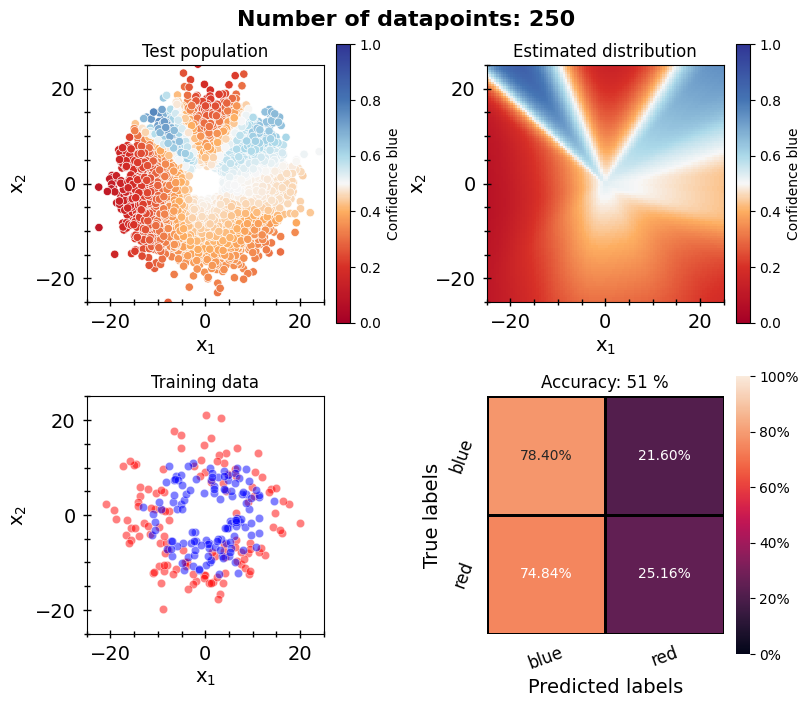

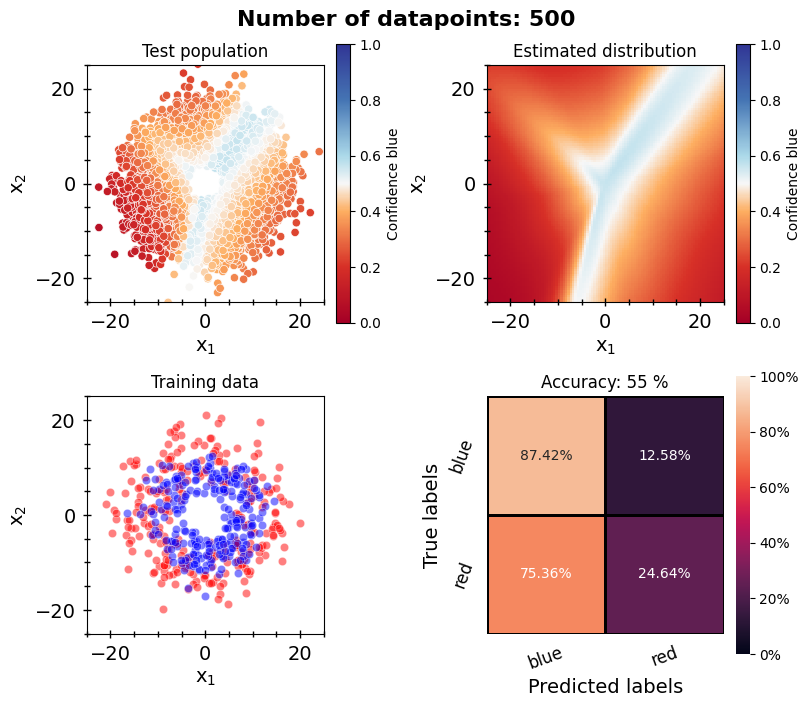

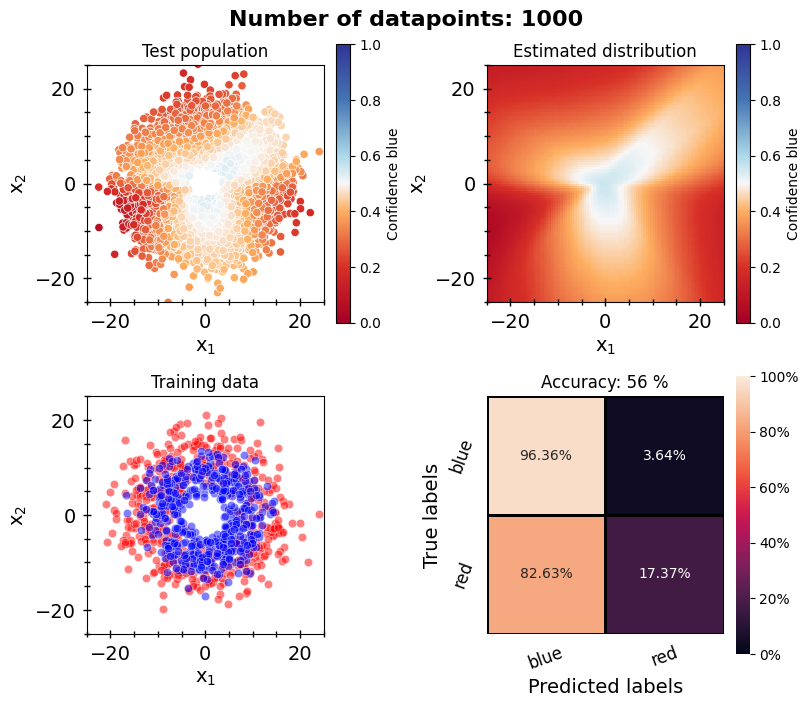

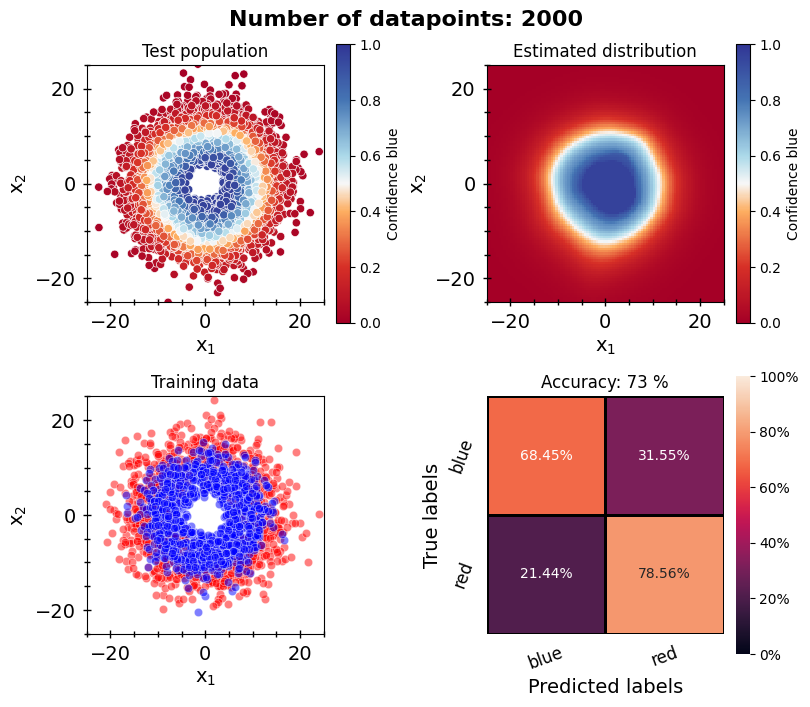

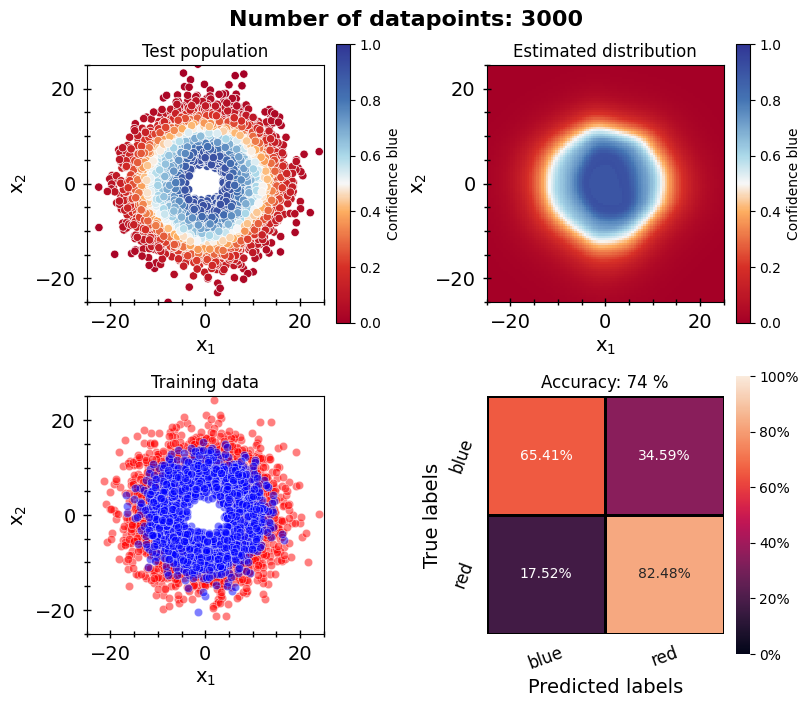

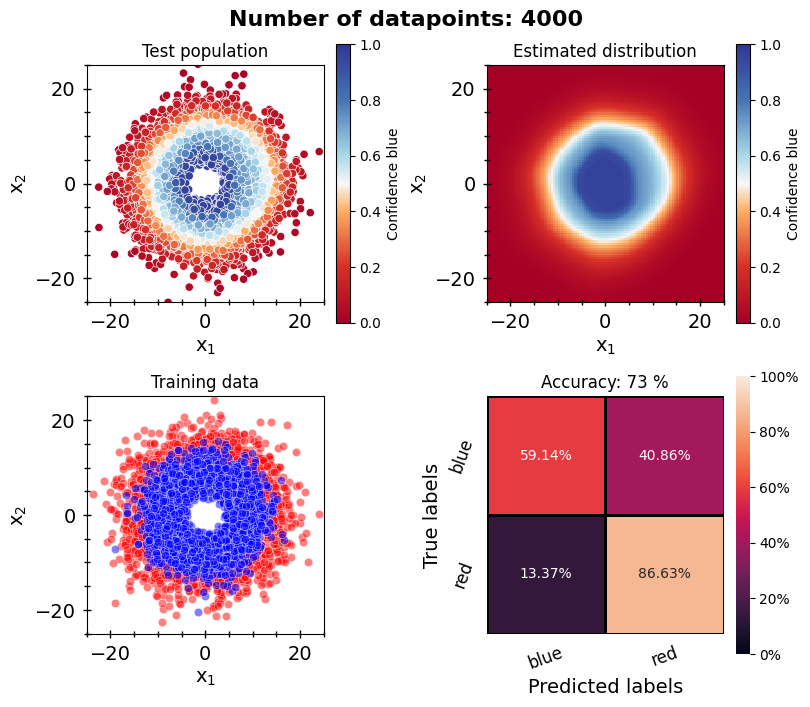

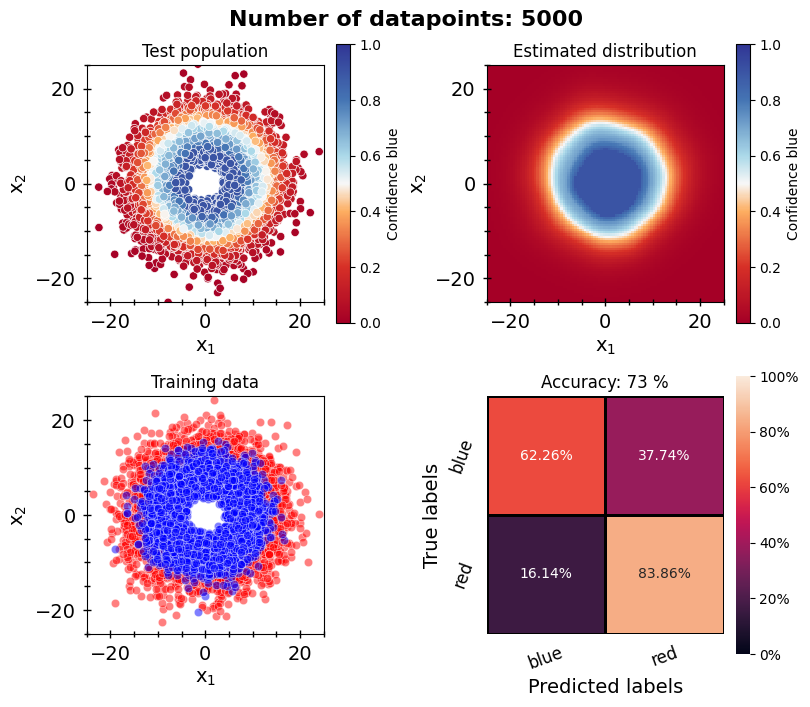

In [32]:
# Plot
for i in range(len(n_data)):
    fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (8, 7), layout="constrained")

    axs[0][0] = plot_results(val_data_dfs[i], "Confidence", axs[0][0], "Test population")
    axs[0][1] = plot_grid(grid_dfs[i], "Confidence", axs[0][1], "Estimated distribution")
    axs[1][1] = plot_conf_matrix(val_data_dfs[i], "Truth", "Prediction", ["blue", "red"], axs[1][1])
    axs[1][0] = plot_data(train_data[0:n_data[i]], axs[1][0], "Training data")

    cmap = red_blue_cmap()
    hue_norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False)
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=cmap), label=r'Confidence blue', ax=axs[0][0])
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=cmap), label=r'Confidence blue', ax=axs[0][1])

    fig.suptitle(f"Number of datapoints: {n_data[i]}", size=16, fontweight="bold")

### Plot MC dropout during training and inference results

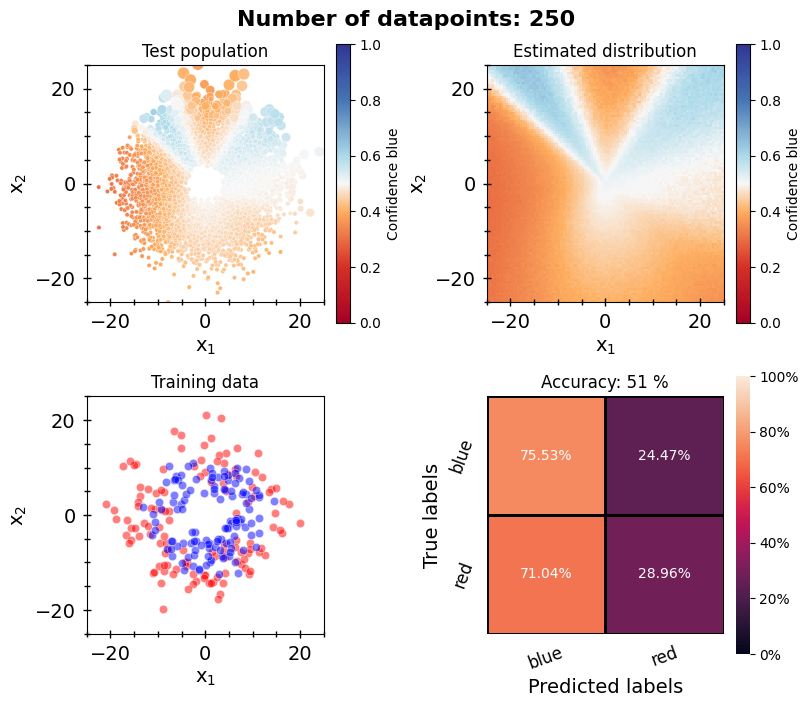

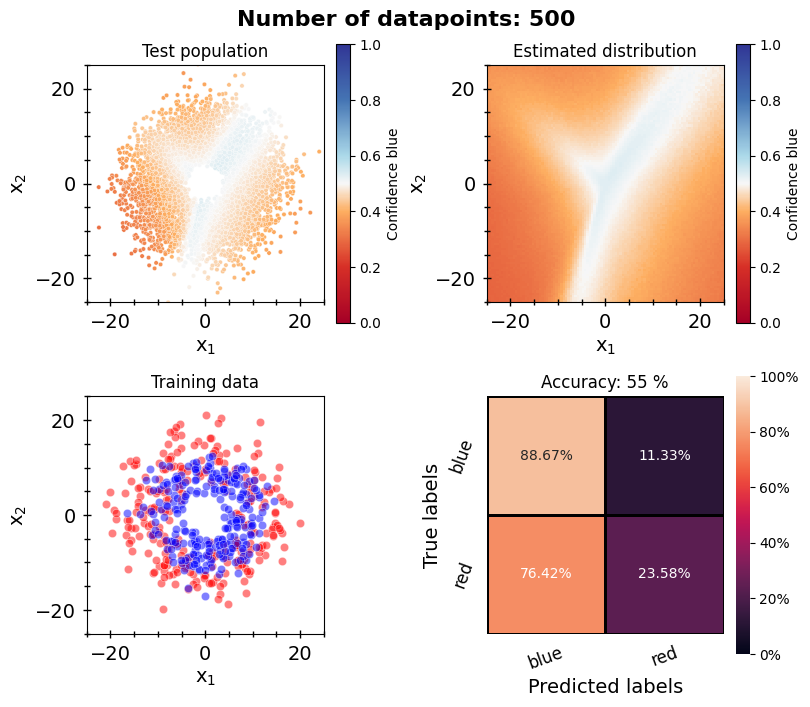

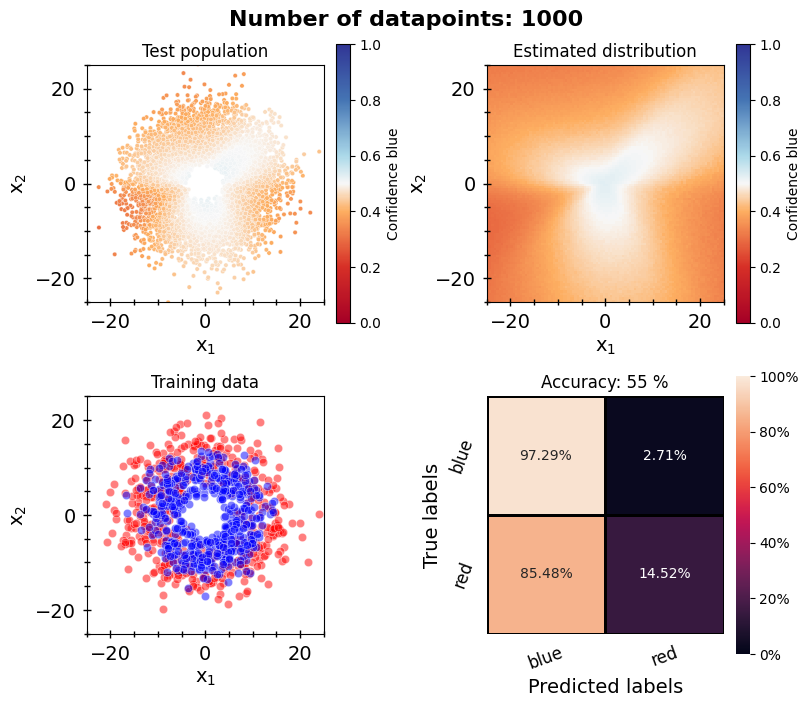

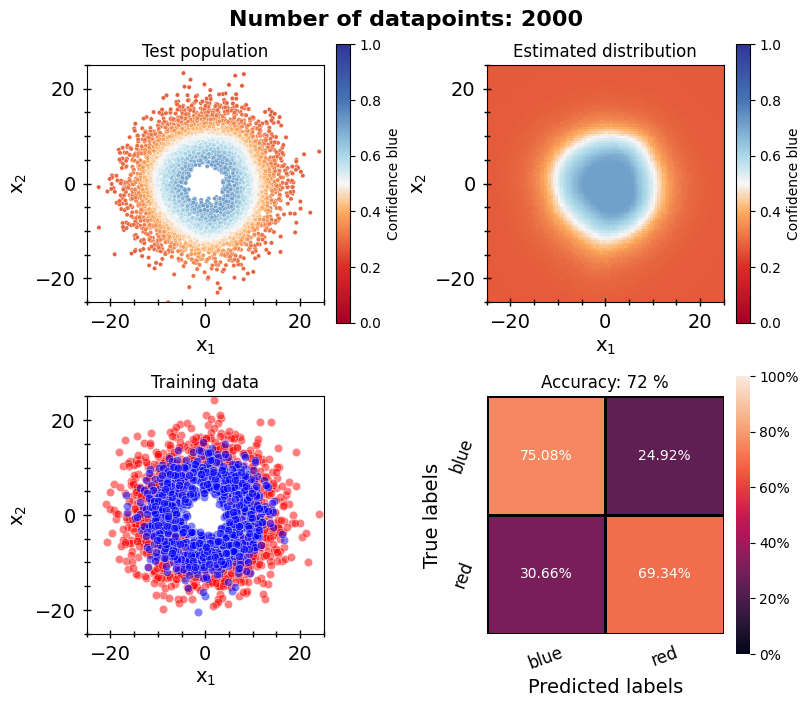

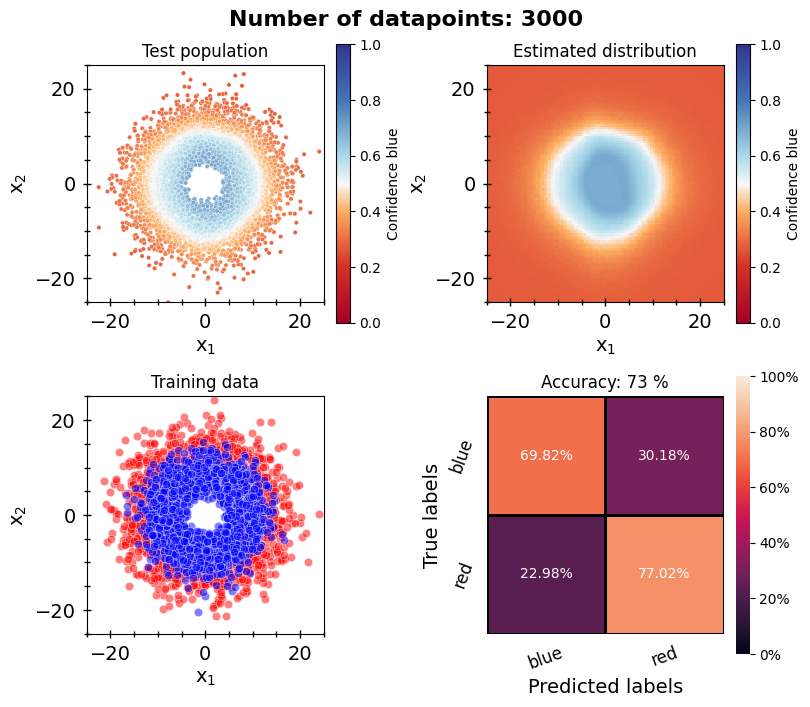

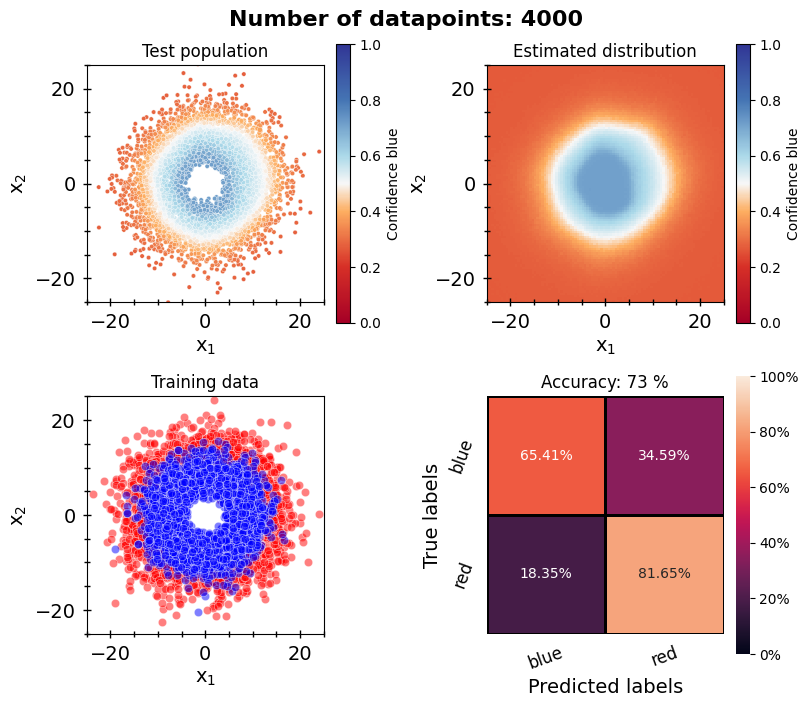

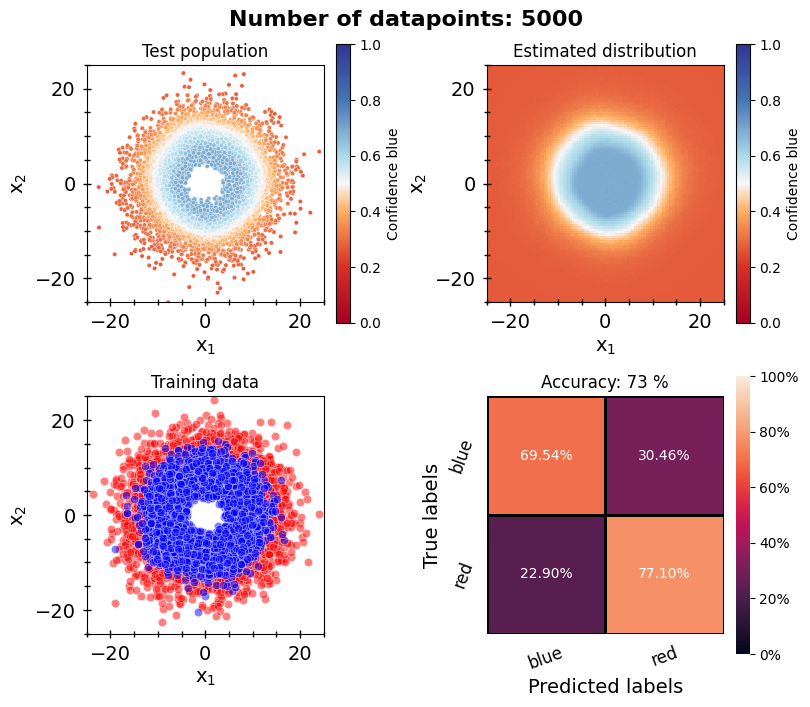

In [33]:
# Plot
for i in range(len(n_data)):
    fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (8, 7), layout="constrained")

    axs[0][0] = plot_results(val_data_dfs[i], "Confidence_MC", axs[0][0], "Test population", error_key="Error_MC")
    axs[0][1] = plot_grid(grid_MC_dfs[i], "Confidence_MC", axs[0][1], "Estimated distribution")
    axs[1][1] = plot_conf_matrix(val_data_dfs[i], "Truth", "Prediction_MC", ["blue", "red"], axs[1][1])
    axs[1][0] = plot_data(train_data[0:n_data[i]], axs[1][0], "Training data")

    cmap = red_blue_cmap()
    hue_norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False)
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=cmap), label=r'Confidence blue', ax=axs[0][0])
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=cmap), label=r'Confidence blue', ax=axs[0][1])

    fig.suptitle(f"Number of datapoints: {n_data[i]}", size=16, fontweight="bold")


In [34]:
val_data

color         x1         x2        a1        a2         r1  r2  \
0      red -10.685982   0.247318  3.107515  3.102613  13.685925   3   
1      red   6.517934  18.842814  1.225701  0.080292  16.946496   3   
2     blue  10.101325   7.399758  0.591001  0.172946   9.555816   3   
3     blue   6.168565   3.672720  0.340686  2.655884   9.694243   3   
4     blue  -6.823455  -6.068953  3.562035  1.977482   9.893021   3   
...    ...        ...        ...       ...       ...        ...  ..   
4995  blue  10.516936   4.502822  0.285772  0.468822   8.683448   3   
4996   red  11.995977 -10.837092  5.447627  2.568009  18.603909   3   
4997  blue  -2.321882  -5.453356  3.916992  2.283827   7.437896   3   
4998   red  13.664635   7.015536  0.412229  0.323295  12.486160   3   
4999   red  10.134063   3.073077  0.009755  1.702359  10.557108   3   

            r_x       a_x  class  
0     10.688843  3.118453      0  
1     19.938283  1.237769      0  
2     12.521709  0.632241      1  
3      7.179141  0.537025      1  
4      9.131907  3.868535      1  
...         ...       ...    ...  
4995  11.440339  0.404535      1  
4996  16.166200  5.548498      0  
4997   5.927076  4.309865      1  
4998  15.360338  0.474317      0  
4999  10.589761  0.294429      0  

[5000 rows x 10 columns]

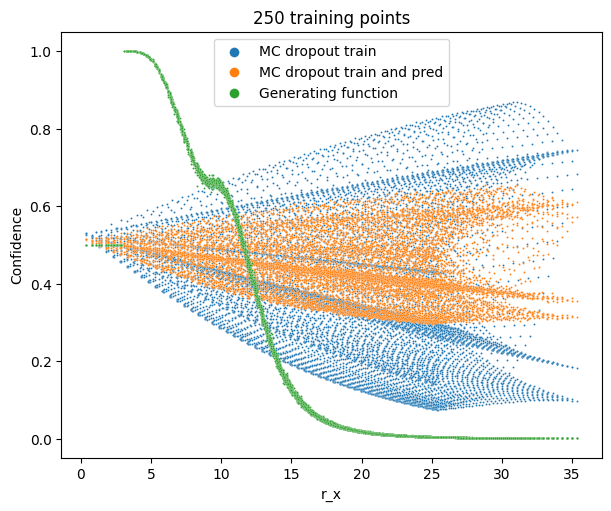

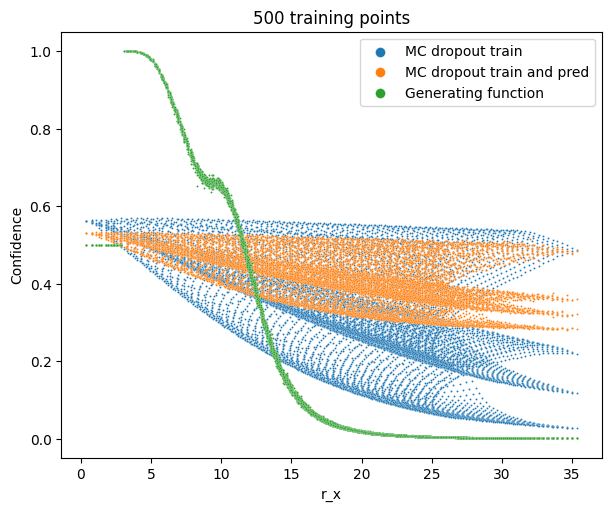

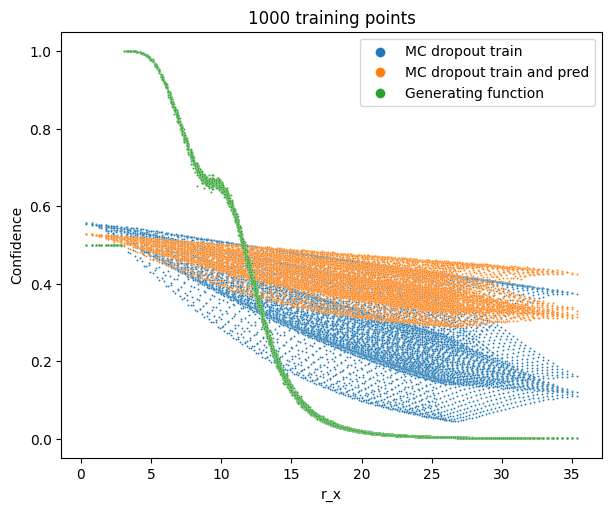

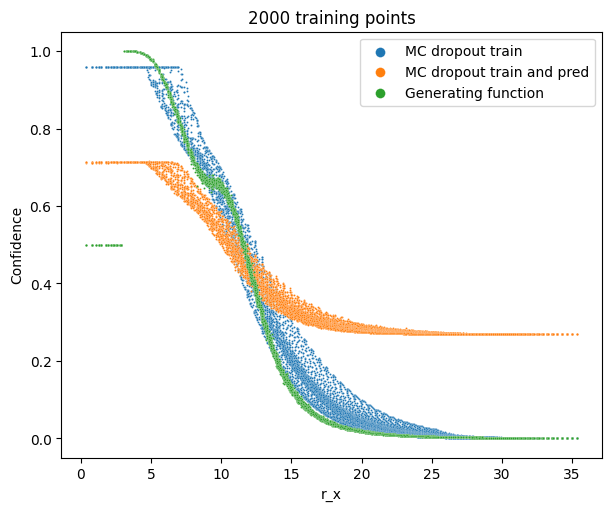

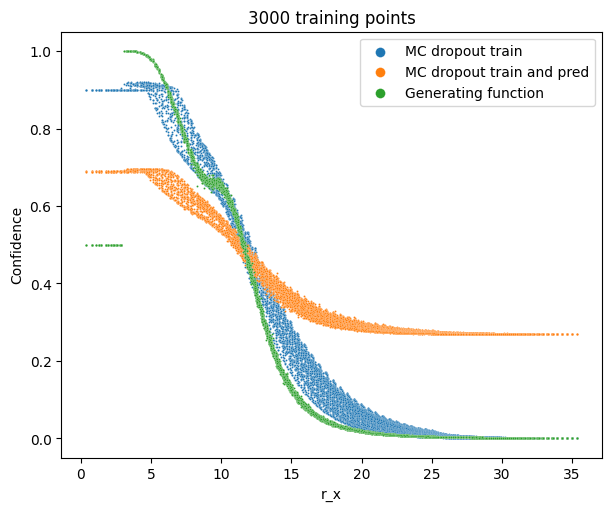

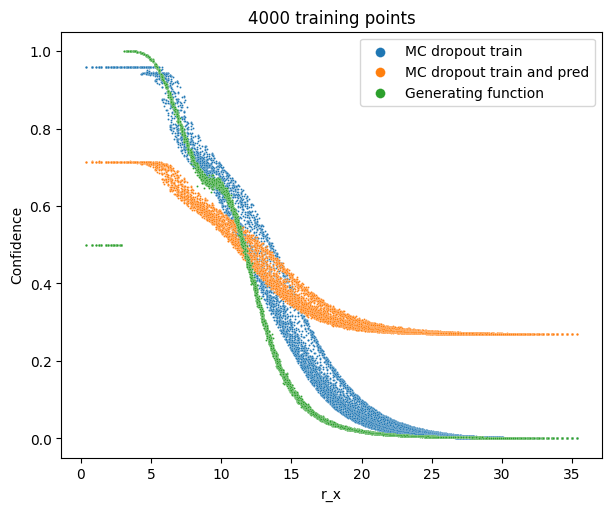

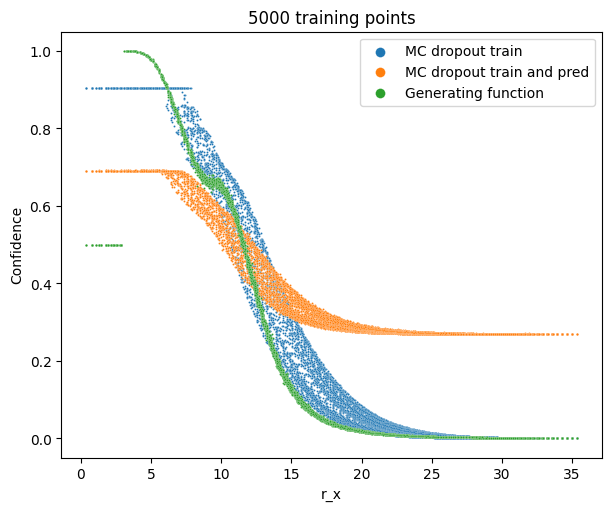

In [35]:
for i in range(len(n_data)):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize= (6, 5), layout="constrained")
    sn.scatterplot(grid_dfs[i], x="r_x", y="Confidence", s=2, label="MC dropout train", ax = ax)
    sn.scatterplot(grid_MC_dfs[i], x="r_x", y="Confidence_MC", s=2, label="MC dropout train and pred", ax = ax)
    sn.scatterplot(truth_data, x="r_x", y="P_blue_given_x", s=2, ax = ax, label="Generating function")
    ax.legend(markerscale=5)
    ax.set_title(f"{n_data[i]} training points")

In [36]:
from sklearn.calibration import CalibrationDisplay
from sklearn.calibration import calibration_curve

#Get confidence for red
val_data["Confidence_MC"] = scipy.special.softmax(mean_val, axis=-1)[:,1]
prob_cal_MC, prob_pred_MC = calibration_curve(val_data["Truth"], val_data["Confidence_MC"], n_bins=40, strategy="uniform")
pred_bins_MC=list(prob_pred_MC)

#Get confidence for red
val_data["Confidence"] = torch.softmax(logits, dim=-1)[:,1]
prob_cal, prob_pred = calibration_curve(val_data["Truth"], val_data["Confidence"], n_bins=40, strategy="uniform")
pred_bins=list(prob_pred)

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 13))
sn.histplot(val_data, x="Confidence_MC", hue="color", ax=ax[0], stat="count", bins=pred_bins_MC)
ax[0].set_xlim(0,1)
ax[1].plot(prob_pred_MC, prob_cal_MC, linewidth=5, markersize=10, marker="o", label ="DNN_MC_infer")
ax[1].plot(prob_pred, prob_cal, linewidth=5, markersize=10, marker="o", label ="DNN_MC_train")
ax[1].set_xlim(0,1.1)
ax[1].set_ylim(0,1.1)
x = np.linspace(0, 1, 10)
ax[1].plot(x, x, color="black", linestyle="--", label="Perfectly calibrated")
ax[1].set_xlabel("Confidence")
ax[1].set_ylabel("Calibrated confidence")
ax[1].legend()

KeyError: 'Truth'